In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np
from functools import partial

from tqdm import tqdm as tqdm
from setup_visdom import setup_visdom

from poptorch.distributions.functional import log_gaussian, gaussian_reparameterization as reparameterize

In [2]:
import sys
sys.path.append('/home/angusturner/autoencoders/src')

from abs_worker import AbstractWorker

In [3]:
DATA_DIR = "/home/angusturner/data/"

### Dataset

In [4]:
class MNIST:
    mean = 0.1307
    std = 0.3081
    default_transforms = transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((mean,), (std,))
    ])
    def __init__(self, data_dir, train: bool = True):
        """
        :param data_dir: location to save
        :param train:
        """
        self.dataset = datasets.MNIST(
            data_dir,
            train=train,
            transform=MNIST.default_transforms,
            download=True
        )

    def __len__(self):
        return len(self.dataset)
    
    @staticmethod
    def denormalize(im):
        """
        :param im: (B, C, H, W)
        """
        return (im + 1) / 2.
#         return (im * MNIST.std) + MNIST.mean

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        x = np.array(x).astype(np.float32)
        x = (x * 2.) - 1
        
        return x, y

In [5]:
LOADER_OPTS = {
    'batch_size': 32,
    'shuffle': True,
    'drop_last': True
}

In [6]:
train_dataset = MNIST(DATA_DIR, train=True)
test_dataset = MNIST(DATA_DIR, train=False)
train_loader = torch.utils.data.DataLoader(train_dataset, **LOADER_OPTS)
test_loader = torch.utils.data.DataLoader(test_dataset, **LOADER_OPTS)

In [7]:
x, y = next(train_loader.__iter__())

print(x.mean(), x.std())

x_denorm = MNIST.denormalize(x)
print(x_denorm.mean(), x_denorm.std())

tensor(-0.7461) tensor(0.6087)
tensor(0.1269) tensor(0.3043)


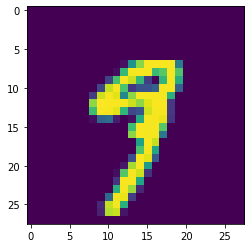

In [8]:
plt.imshow(x_denorm.numpy()[0, 0])
plt.imshow(x.numpy()[0, 0])

### Define the Model

In [9]:
class DownsampleBlock(nn.Module):
    def __init__(self, hidden):
        super(DownsampleBlock, self).__init__()

        self.main = nn.Conv2d(hidden, hidden * 2, kernel_size=2, stride=2)
        self.skip = nn.Conv2d(hidden, hidden * 2, kernel_size=2, stride=2)

    def forward(self, x, skip):
        x = self.main(x)
        skip = self.skip(skip)
        return x, skip
    
class UpsampleBlock(nn.Module):
    def __init__(self, hidden):
        super(UpsampleBlock, self).__init__()

        self.main = nn.ConvTranspose2d(hidden, hidden // 2, kernel_size=2, stride=2)
        self.skip = nn.ConvTranspose2d(hidden, hidden // 2, kernel_size=2, stride=2)

    def forward(self, x, skip):
        x = self.main(x)
        skip = self.skip(skip)
        return x, skip

In [10]:
class ConvGLU(nn.Module):
    def __init__(self, channels, c_dim=None, dilation=1, kw=3):
        super().__init__()
        
        self.bn = nn.BatchNorm2d(channels)
        
        # main op. + parameterised residual connection
        padding = (kw - 1) * dilation // 2
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, dilation=dilation, padding=padding)
        self.up1x1 = nn.Conv2d(channels // 2, channels, 1)
        
        # parameterised skip connection
        self.skip1x1 = nn.Conv2d(channels // 2, channels, 1)
        
        self.rescale = 0.5 ** 0.5
        
        if c_dim is not None:
            self.c_proj = nn.Linear(c_dim, channels)
            
    def forward(self, x, skip, c=None):
        """
        :param x: (B, C H, W)
        :param skip: (B, C, H, W)
        """
        h = self.bn(x)
        h = self.conv(h)
        a, b = torch.chunk(h, 2, 1) # (B, C // 2, H, W)
        
        if c is not None:
            assert hasattr(self, 'c_proj'), "Oops, conditioning dim not specified!"
            batch = x.shape[0]
            c_proj = self.c_proj(c)
            c_a, c_b = torch.chunk(c_proj, 2, -1) # (B, C // 2)
            c_a = c_a.reshape(batch, -1, 1, 1) # (B, C // 2, H=1, W=1)
            c_b = c_b.reshape(batch, -1, 1, 1)
            a = (a + c_a) * self.rescale
            b = (b + c_b) * self.rescale
        
        out = torch.sigmoid(a) * b
        
        # accumulate skip values
        skip = self.rescale * (self.skip1x1(out) + skip) # (B, C, H, W)
        
        # residual connection
        out = self.up1x1(out)
        out = self.rescale * (out + x) # (B, C, H, W)
            
        return out, skip

In [11]:
class ScoreNetwork(nn.Module):
    def __init__(self, input_dim=1, hidden=64, output_dim=1, c_dim=64, nb_timesteps=50):
        super().__init__()
        
        # create positional embeddings (Vaswani et al, 2018)
        dims = torch.arange(c_dim // 2).unsqueeze(0) # (1, c_dim  // 2)
        steps = torch.arange(nb_timesteps).unsqueeze(1) # (nb_timesteps, 1)
        first_half = torch.sin(steps * 10. ** (dims * 4. / (c_dim // 2 - 1)))
        second_half = torch.cos(steps * 10. ** (dims * 4. / (c_dim // 2 - 1)))
        diff_embedding = torch.cat((first_half, second_half), dim=1) # (nb_timesteps, c_dim)
        self.register_buffer('diff_embedding', diff_embedding)
        
        self.init = nn.Conv2d(input_dim, hidden, 1)
        self.init_skip = nn.Conv2d(input_dim, hidden, 1)
        
        # 28x28
        self.l1 = ConvGLU(hidden, c_dim)
        self.down1 = DownsampleBlock(hidden)
        
        # 14x14
        self.l2 = ConvGLU(hidden * 2, c_dim)
        self.down2 = DownsampleBlock(hidden * 2)
        
        # 7x7
        self.l3 = ConvGLU(hidden * 4, c_dim, dilation=1)
        self.l4 = ConvGLU(hidden * 4, c_dim, dilation=2)
        
        # 14x14
        self.up1 = UpsampleBlock(hidden * 4)
        self.l5 = ConvGLU(hidden * 2, c_dim)
        
        # 28x28
        self.up2 = UpsampleBlock(hidden * 2)
        self.l6 = ConvGLU(hidden, c_dim)
        
        self.rescale = 0.5 ** 0.5
    
        self.out = nn.Sequential(
            nn.Conv2d(hidden, hidden * 2, 1),
            nn.LeakyReLU(),
            nn.Conv2d(hidden * 2, 1, 1)
        )
        
    def forward(self, x, t):
        """
        Produces an estimate for the noise term `epsilon`. 
        Can equivalently be thought of as a learned gradient or "score function" estimator,
        as part of a Langevin sampling procedure.
        :param x: (batch, 1, H, W) torch.float
        :param t: (batch) torch.int
        """
        batch = x.shape[0]
        c = self.diff_embedding[t] # (batch, c_dim)
        
        # initial channel upsampling
        out = self.init(x)
        skip = self.init_skip(x)
        
        # 28x28
        out, skip = self.l1(out, skip, c)
        out_half, skip_half = self.down1(out, skip)
        
        # 14x14
        out_half, skip_half = self.l2(out_half, skip_half, c)
        out_quart, skip_quart = self.down2(out_half, skip_half)
        
        # 7x7
        out_quart, skip_quart = self.l3(out_quart, skip_quart, c)
        out_quart, skip_quart = self.l4(out_quart, skip_quart, c)
        
        # back to 14x14
        out_half_, skip_half_ = self.up1(out_quart, skip_quart)
        out_half = self.rescale * (out_half + out_half_)
        skip_half = self.rescale * (skip_half + skip_half_)
        
        # 14x14
        out_half, skip_half = self.l5(out_half, skip_half)
        
        # back to 28x28
        out_, skip_ = self.up2(out_half, skip_half)
        out = self.rescale * (out + out_)
        skip = self.rescale * (skip + skip_)
        
        out, skip = self.l6(out, skip, c)
        out = self.out(skip)
        
        return out

In [12]:
class DiffusionProcess(nn.Module):
    def __init__(self, nb_timesteps=50, start=1e-4, end=0.05):
        super().__init__()
        
        self.nb_timesteps = nb_timesteps
        
        # beta = likelihood variance q(x_t | x_t-1)
        beta = torch.linspace(start, end, nb_timesteps)
        alpha = 1. - beta
        alpha_hat = alpha.cumprod(dim=0)
        
        # q(x_t|x_0) = N(x_t ; sqrt(alpha_hat) * x_0, forward_variance)
        prior_variance = (1. - alpha_hat)
        
        # forward process posterior variance (beta_hat) corresponding to (q(x_t-1 | x_t, x_0)
        alpha_hat_t_1 = F.pad(alpha_hat, (1, 0))[:-1]
        posterior_variance = (1 - alpha_hat_t_1) * beta / (1 - alpha_hat)
        posterior_variance[0] = beta[0]
        
        for (name, tensor) in [
            ("beta", beta),
            ("alpha", alpha),
            ("alpha_hat", alpha_hat),
            ("prior_variance", prior_variance),
            ("posterior_variance", posterior_variance)
        ]:
            self.register_buffer(name, tensor)
    
    def sample_t(self, batch_size=1, device=None):
        """
        Sample a random timestep for each batch item.
        """
        return torch.randint(0, self.nb_timesteps, size=(batch_size,), device=device)
        
    def sample_q(self, x0, eps, t):
        """
        Draw a sample from q(x_t|x0)
        :param x0: the initial data point (batch, *)
        :param eps: noise samples from N(0, I) (batch, *)
        :param t: the timesteps in [0, nb_timesteps] (batch)
        """
        assert (t >= 0).all() and (t < self.nb_timesteps).all(), "Invalid timestep"
        
        alpha_hat_t = self.alpha_hat[t, None, None, None] # (batch, 1, 1, 1)
        return alpha_hat_t.sqrt() * x0 + (1. - alpha_hat_t).sqrt() * eps
    
    def sample_p(self, x_t, eps_hat, t, greedy=False):
        """
        Draw a sample from p(x_t-1|x_t)
        :param x_t: the previous sample (batch, *)
        :param eps_hat: (batch, *)
        :param t: the timestep (batch)
        """
        
        alpha_t = self.alpha[t, None, None, None] # (batch, 1, 1, 1)
        beta_t = self.beta[t, None, None, None]
        alpha_hat_t = self.alpha_hat[t, None, None, None]
        
        # calculate the mean
        mu = x_t - ((beta_t * eps_hat) / (1. - alpha_hat_t).sqrt())
        mu = (1. / alpha_t.sqrt()) * mu
        
        if greedy:
            return mu
        
        # sample
        std = self.posterior_variance[t, None, None, None].sqrt()
        x_next = mu + std * torch.randn_like(mu)
        
        return x_next

### Visualise the Parameters of the Diffusion Process

In [13]:
nb_steps = 1000
start = 1e-4
end = 1e-2
diff_process = DiffusionProcess(nb_steps, start, end)
print(diff_process.prior_variance[-1])
print(diff_process.prior_variance[0])

print(diff_process.posterior_variance[0])
print(diff_process.beta[0])

tensor(0.9937)
tensor(0.0001)
tensor(1.0000e-04)
tensor(1.0000e-04)


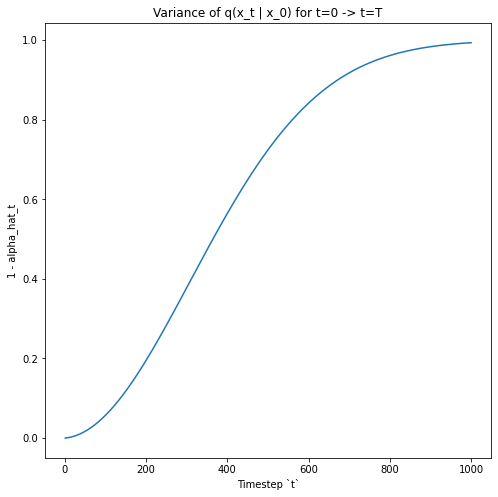

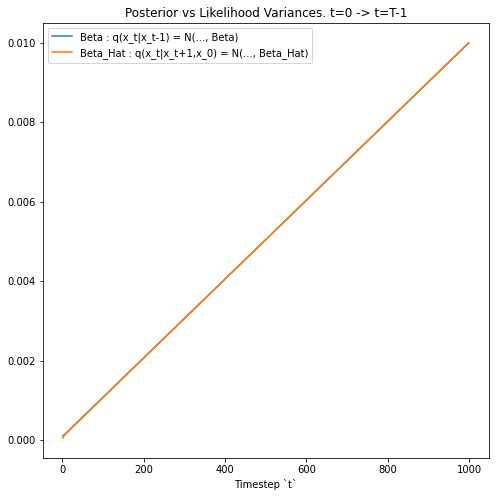

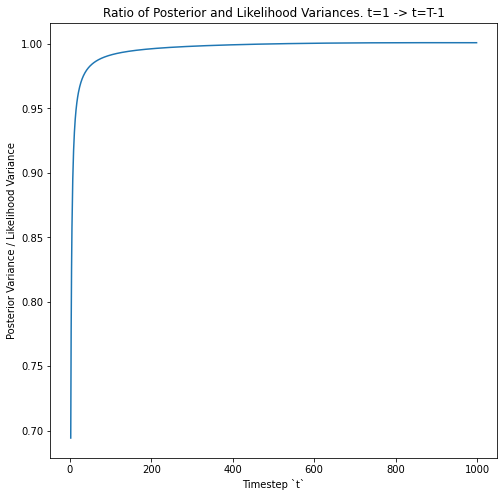

In [14]:
# visualise the various terms

t = torch.arange(1, nb_steps+1)
plt.figure(figsize=(8, 8))
plt.title("Variance of q(x_t | x_0) for t=0 -> t=T")
plt.xlabel("Timestep `t`")
plt.ylabel("1 - alpha_hat_t")
plt.plot(t[:], diff_process.prior_variance[:])
plt.show()

plt.figure(figsize=(8, 8))
plt.title("Posterior vs Likelihood Variances. t=0 -> t=T-1")
plt.xlabel("Timestep `t`")
plt.plot(t[0:-1], diff_process.beta[:-1])
plt.plot(t[0:-1], diff_process.posterior_variance[1:])
plt.legend([
    "Beta : q(x_t|x_t-1) = N(..., Beta)", 
    "Beta_Hat : q(x_t|x_t+1,x_0) = N(..., Beta_Hat)"
])
plt.show()

plt.figure(figsize=(8, 8))
plt.title("Ratio of Posterior and Likelihood Variances. t=1 -> t=T-1")
plt.xlabel("Timestep `t`")
plt.ylabel("Posterior Variance / Likelihood Variance")
plt.plot(t[1:-1], (diff_process.posterior_variance[2:] / diff_process.beta[1:-1]))
plt.show()


# plt.plot(t[1:], fwd_model.posterior_variance[1:])

### Wrap Forward and Reverse Process into Single Model

In [15]:
class DiffusionModel(nn.Module):
    def __init__(self, diffusion, score, **kwargs):
        super().__init__()
        
        self.diffusion = DiffusionProcess(**{**kwargs, **diffusion})
        self.score = ScoreNetwork(**{**kwargs, **score})
        
        self.params = [p for p in self.parameters() if p.requires_grad]
    
    def forward(self, x0):
        """
        :param x0: (batch, features)
        """
        eps = torch.randn_like(x0)
        t = self.diffusion.sample_t(eps.shape[0], device=eps.device)
        x_t = self.diffusion.sample_q(x0, eps, t)
        eps_hat = self.score(x_t, t)
        
        return F.mse_loss(eps_hat, eps, reduction='mean')
        
    def generate(self, shape, device=None):
        """
        :param shape: a tuple indicating the shape of the data
        :param device: which device to sample on
        """
        batch, *_ = shape
        x_T = torch.randn(shape, device=device)
        
        x = x_T
        
        
        out = [x_T.cpu()]
        for t in range(self.diffusion.nb_timesteps-1, -1, -1):
            t_ = torch.full((batch,), t, dtype=torch.long, device=device)
            
            eps_hat = self.score(x, t_)
            x = self.diffusion.sample_p(x, eps_hat, t_, greedy=t==0)
            
            if (t+1) % 20 == 0:
                out.append(x.cpu())
        
        return x, out

### Worker

In [16]:
class Worker(AbstractWorker):
    def __init__(self, model, lr=2e-4, **kwargs):
        super(Worker, self).__init__(**kwargs)
        
        self.model = model
        self.kwargs = kwargs
        self.plot_freq = 100
        self._no_plot = 0
        
        self.optim = torch.optim.Adam(self.model.params, lr=lr)
        
    def work(self, loader, train=True):
        losses = []
        for i, features in enumerate(tqdm(loader)):
            if train:
                self.optim.zero_grad()
            
            # put features on GPU
            x, _ = features
            batch = x.shape[0]
            x = x.float().cuda()
            
            loss = self.model(x)
            if torch.isnan(loss).any():
                raise Exception("NaN :(")
            
            losses.append(loss.item())
            
            if train:
                loss.backward()
                self.optim.step()
            
            self.plot_loss({
                'MSE': loss.item()
            }, id='Train' if train else 'Test', archive=False)
        
        
        if not train:
            self._plot_sample()
        
        return np.mean(losses),
    
    @torch.no_grad()
    def _plot_sample(self):
        x_gen, _ = self.model.generate((1, 1, 28, 28), device='cuda')
#         x_gen = MNIST.denormalize(x_gen).clamp(0, 1)
        x_np = x_gen.view(28, 28).cpu().numpy()
        self.plot_heatmap(x_np, id='Generated Sample')
    
    def train(self, loader):
        self.model.train()
        return self.work(loader, train=True)
        
    @torch.no_grad()
    def test(self, loader):
        self.model.eval()
        return self.work(loader, train=False)

### Model Setup

In [17]:
config = {
    'score': {},
    'diffusion': {
        'start': 1e-4,
        'end': 0.05
    },
    'nb_timesteps': 200
}

MODEL_DIR = "/home/angusturner/data/models/"
TEST_NO = "mnist_unet"

In [18]:
model = DiffusionModel(**config).cuda()
vis = setup_visdom(TEST_NO)

In [19]:
worker = Worker(model, vis=vis, model_dir=MODEL_DIR, test_no=TEST_NO, lr=1e-3)

### Train

In [20]:
nb_epoch = 10
lowest_loss = float('inf')

In [21]:
for e in range(nb_epoch):
    worker.train(train_loader)
    loss, = worker.test(test_loader)
    
    if loss < lowest_loss:
        print(f"New lowest loss {loss}")
        lowest_loss = loss
        worker.save(info='best')

  0%|          | 5/1875 [00:00<00:42, 44.11it/s]

New lowest loss 0.047285839855575405
Model saved at /home/angusturner/data/models//mnist_unet/checkpoint_best.tar


  0%|          | 5/1875 [00:00<00:43, 43.33it/s]

New lowest loss 0.043695739374902
Model saved at /home/angusturner/data/models//mnist_unet/checkpoint_best.tar


  0%|          | 4/1875 [00:00<00:54, 34.49it/s]

New lowest loss 0.040478020530337326
Model saved at /home/angusturner/data/models//mnist_unet/checkpoint_best.tar


  0%|          | 5/1875 [00:00<00:41, 45.49it/s]

New lowest loss 0.03917392281194528
Model saved at /home/angusturner/data/models//mnist_unet/checkpoint_best.tar


  0%|          | 4/1875 [00:00<00:49, 37.46it/s]

New lowest loss 0.03682700422807382
Model saved at /home/angusturner/data/models//mnist_unet/checkpoint_best.tar


  0%|          | 5/1875 [00:00<00:43, 43.01it/s]

New lowest loss 0.036045792214094825
Model saved at /home/angusturner/data/models//mnist_unet/checkpoint_best.tar


 14%|█▍        | 263/1875 [00:06<00:36, 43.71it/s]


KeyboardInterrupt: 

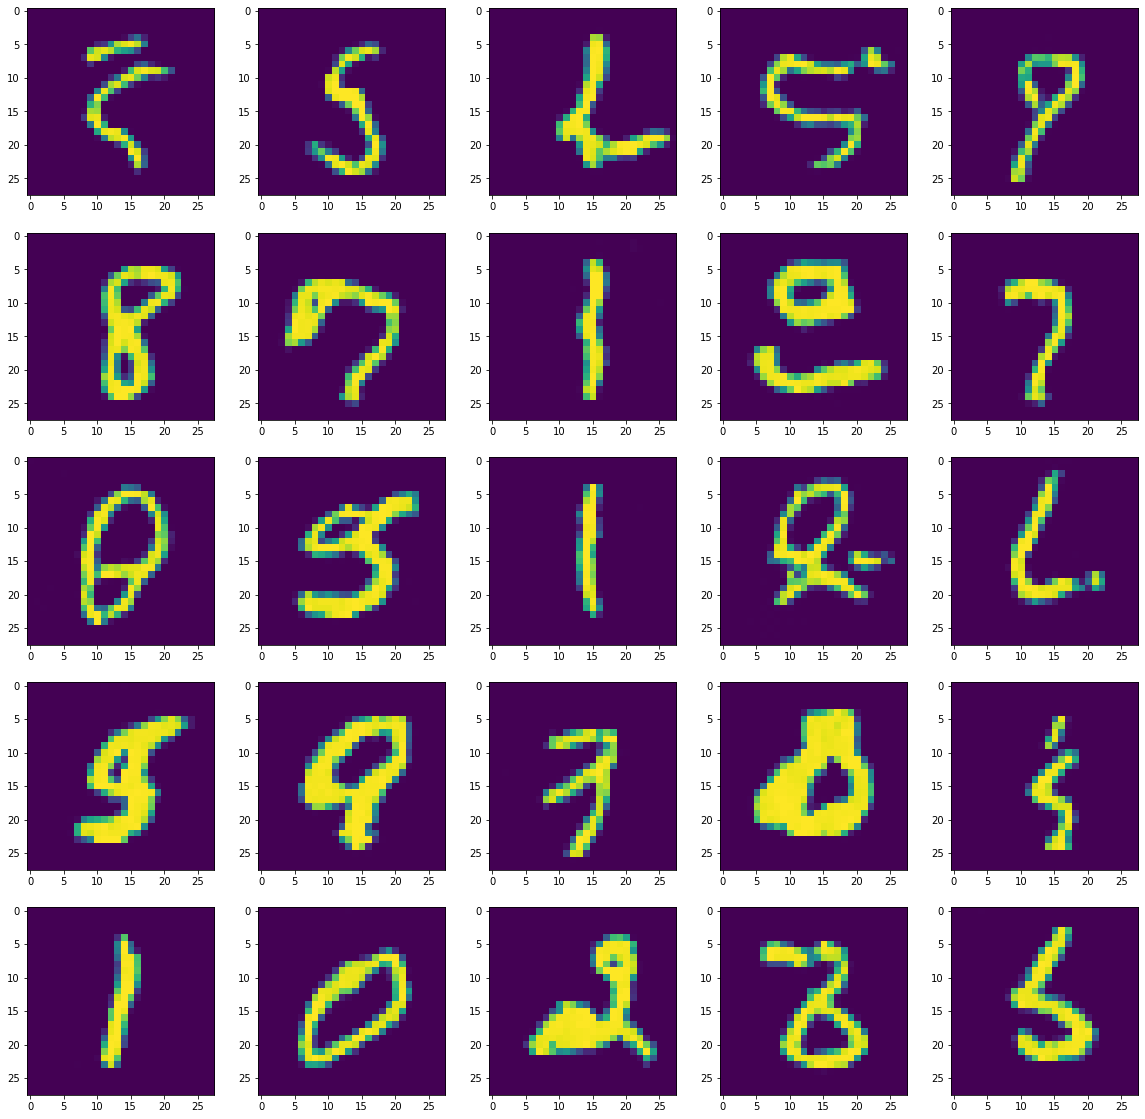

In [22]:
with torch.no_grad():
    worker.model.eval()
    x_gen, _ = worker.model.generate((25, 1, 28, 28), device='cuda')
    x_gen = MNIST.denormalize(x_gen.cpu()).clamp(0, 1)
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(x_gen[i].view(28, 28).numpy())

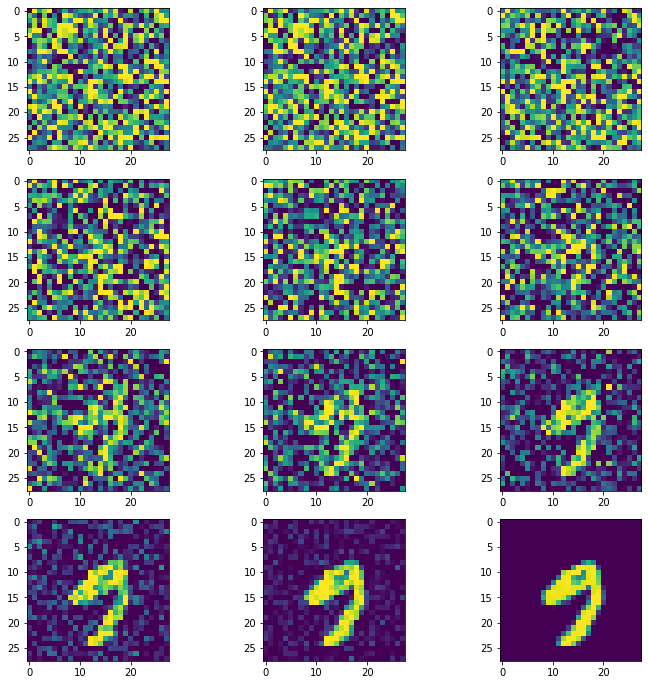

In [23]:
with torch.no_grad():
    worker.model.eval()
    x_gen, intermediates = worker.model.generate((1, 1, 28, 28), device='cuda')
    intermediates.append(x_gen.cpu())
        
    fig = plt.figure(figsize=(12, 12))
    
    for i, x_gen in enumerate(intermediates):
        x_gen = MNIST.denormalize(x_gen.cpu()).clamp(0, 1)
        plt.subplot(4, 3, i+1)
        plt.imshow(x_gen.view(28, 28).numpy())